In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [235]:
def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
#         inputs.append([0.1 * i, 1 - 0.1*i])
#         labels.append(1)        
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)


        if 0.1 * i == 0.5:
            continue

        inputs.append([0.1 * i, 1 - 0.1*i])
        labels.append(1)        

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [236]:
def plot_data(X, y, pred_y):
    print("Acc: ", 1 - np.mean(abs(y - pred_y)))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))
    color_real = ['red' if l == 0 else 'green' for l in y]
    color_pred = ['red' if l == 0 else 'green' for l in pred_y]
    
    ax[0].scatter(X[:, 0], X[:, 1], color=color_real)
    ax[0].set_aspect("equal")
    ax[0].title.set_text("real")

    ax[1].scatter(X[:, 0], X[:, 1], color=color_pred)
    ax[1].title.set_text("predict")
    ax[1].set_aspect("equal")
    plt.show()

In [329]:
class Model():
    # input is 3d(x, y coordinate + 1 for bias), output is 1d
    # 2 hidden layer, 2 neurons for each
    class Layer():
        def __init__(self, size):
            self.d_a_hat = 0
            self.d_a = 0
            self.W = np.random.random(size) * np.sqrt(2 / size[1])
            self.b = np.random.random((1, size[1])) * np.sqrt(2 / size[1])
            self.a_hat = 0
            self.Wm = np.zeros(size)
            self.bm = np.zeros((1, size[1]))
                        
    def __init__(self):
        self.layer = []
    
    def add_layer(self, size):
        l = self.Layer(size)
        self.layer.append(l)
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def derivative_sigmoid(self, x):
        return np.multiply(x, 1.0 - x)
    
    def cal_loss(self, y, pred_y):
        # using cross entropy
#         return (1/2) * np.mean(sum(pow(pred_y - y, 2)))
        return np.mean(-(y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y)))
    
    
    def derivative_loss(self, y, pred_y, batch_size):
#         return (pred_y - y) / batch_size
        return ((-y / pred_y) + (1 - y) / (1 - pred_y))/batch_size
    
    def update_W(self, x, y, pred_y, lr, batch_size):
        num_layer = len(self.layer)
        for i in range(num_layer)[::-1]:
            cur_layer = self.layer[i]
            if i == num_layer - 1:
                cur_layer.d_a_hat = self.derivative_loss(y, pred_y, batch_size)
            else:
                cur_layer.d_a_hat = self.layer[i+1].d_a @ self.layer[i+1].W.T
            cur_layer.d_a = cur_layer.d_a_hat * self.derivative_sigmoid(cur_layer.a_hat)
                         
        for i in range(num_layer):
            cur_layer = self.layer[i]
            if i == 0:
                grad = -lr * np.atleast_2d(x).T @ cur_layer.d_a
            else:
                grad = -lr * self.layer[i-1].a_hat.T @ cur_layer.d_a
            cur_layer.W += grad + cur_layer.Wm
            cur_layer.Wm = cur_layer.Wm * 0.9 + grad * 0.1
            
            grad_b = -lr * np.mean(np.atleast_2d(np.sum(cur_layer.d_a, axis=0)))
            cur_layer.b += grad_b + cur_layer.bm
            cur_layer.bm = cur_layer.bm * 0.9 + grad_b * 0.1
            

    
    def preprocess_x(self, X_train):
        # add bias term
        X_train = np.hstack((X_train, np.ones(X_train.shape[0]).reshape(-1, 1)))
        return X_train
        
    def train(self, X_train, y_train, lr, batch_size=5, iteration=100):        
        loss_acc = []
        batch = list(range(0, X_train.shape[0], batch_size))
        if batch[-1] != X_train.shape[0]:
            batch.append(X_train.shape[0])
        
        for i in range(iteration):
            pred_y = []
            for k in range(len(batch)-1):
                x = X_train[batch[k]:batch[k+1]]
                y = y_train[batch[k]:batch[k+1]]
                in_data = np.atleast_2d(x)
                for j in range(len(self.layer)):
                    self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                    in_data = self.layer[j].a_hat
                        
                y_hat = in_data
                loss = self.cal_loss(y, y_hat)
                self.update_W(x, y, y_hat, lr, batch_size)
                pred_y.extend(y_hat)
            
            pred_y = np.array(pred_y)
            loss = np.mean(self.cal_loss(y_train, pred_y))
            loss_acc.append(loss)
            if i % 5000 == 0:
                print("epoch", i, ":", loss)
                
        return loss_acc
        
    def predict(self, X):
        pred_y = []
        for x in X:
            in_data = np.atleast_2d(x)
            for j in range(len(self.layer)):
                self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                in_data = self.layer[j].a_hat

            pred_y.extend(in_data)
        return np.round(np.array(pred_y)), np.array(pred_y)

In [330]:
def shuffle(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

epoch 0 : 1.1221443421593207
epoch 5000 : 0.011633531863692446
epoch 10000 : 0.004944662327875611
epoch 15000 : 0.0028458263713482044
[[9.99999200e-01 9.99999199e-01 9.99999198e-01 2.45694407e-05]
 [2.46181977e-05 9.99999195e-01 9.99999190e-01 9.99998808e-01]
 [9.99999192e-01 2.45902445e-05 9.99999175e-01 9.99999049e-01]
 [9.99718660e-01 9.99994750e-01 3.52440121e-05 9.99997961e-01]
 [9.99999161e-01 2.45614828e-05 9.99999200e-01 9.99999100e-01]
 [9.99999199e-01 9.99999200e-01 9.99999200e-01 2.69557349e-05]
 [2.45972978e-05 9.99999186e-01 9.99999187e-01 9.99999200e-01]
 [9.99999189e-01 2.85657727e-05 9.99999190e-01 9.99999198e-01]
 [3.16519453e-05 2.45832534e-05 9.99999200e-01 3.13009349e-05]
 [9.99999198e-01 9.99999201e-01 9.99999200e-01 9.99999078e-01]
 [9.99999197e-01 9.99999199e-01 9.99999195e-01 2.47372333e-05]
 [9.79899276e-01 9.99607131e-05 9.99999183e-01 9.99999195e-01]
 [9.99997053e-01 9.99999195e-01 2.48778052e-05 9.99999199e-01]
 [2.52172779e-05 2.45670840e-05 9.89348600e-01 

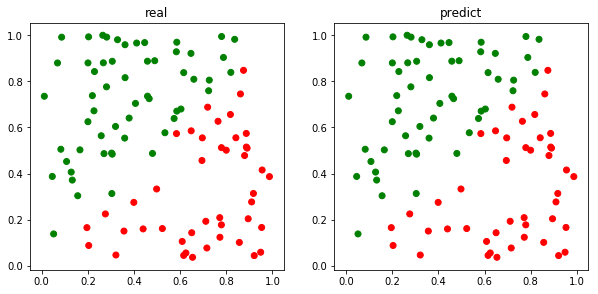

In [331]:
lr = 0.3
batch_size=100
X, y = generate_linear()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size, iteration=20000)
pred_y, pred_y_raw = m.predict(X)
print(pred_y_raw.reshape(-1, 4))
plot_data(X, y, pred_y)

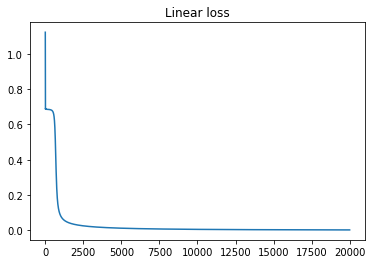

In [332]:
plt.plot(loss)
plt.title("Linear loss")
plt.show()

epoch 0 : 1.0864680684225794
epoch 5000 : 0.6920142042555396
epoch 10000 : 0.6920062643927037
epoch 15000 : 0.6919620641973633
epoch 20000 : 0.29368317984854225
epoch 25000 : 0.0030442880316871365
epoch 30000 : 0.0014363937142162437
epoch 35000 : 0.000934966117495902
epoch 40000 : 0.0006917252588445529
epoch 45000 : 0.0005484132052473449
epoch 50000 : 0.0004540532901522036
epoch 55000 : 0.00038726851585225167
epoch 60000 : 0.0003375343824790967
epoch 65000 : 0.00029907213362442907
epoch 70000 : 0.00026844658705110937
epoch 75000 : 0.00024348825510941014
epoch 80000 : 0.00022275997183331207
epoch 85000 : 0.00020527214791286525
epoch 90000 : 0.00019032123588965056
epoch 95000 : 0.00017739341207642675
prediction: 
 [[9.99923784e-01]
 [9.99922867e-01]
 [9.99923673e-01]
 [2.39971255e-04]
 [8.90023150e-05]
 [9.99489443e-01]
 [8.16635117e-05]
 [3.25827931e-04]
 [9.84410919e-05]
 [9.99915754e-01]
 [7.10915398e-05]
 [1.86599427e-04]
 [7.58264041e-05]
 [9.99687281e-01]
 [9.99802691e-01]
 [9.9980

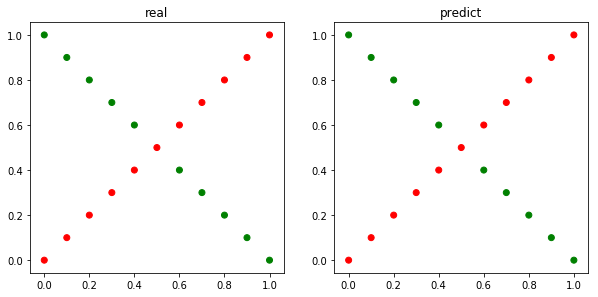

In [323]:
# np.random.seed(1)
lr = 0.35
X, y = generate_XOR_easy()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size=21, iteration=100000)
pred_y, pred_y_raw = m.predict(X)
plot_data(X, y, pred_y)

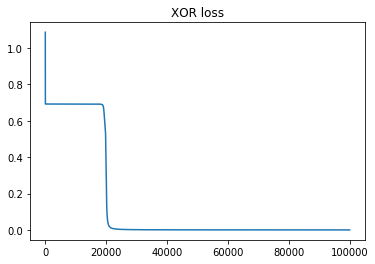

In [324]:
plt.plot(loss)
plt.title("XOR loss")
plt.show()